In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Ingesting Data

In [3]:
df = pd.read_csv('../data/walmart_data.csv')
df.head()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


### Preprocessing

In [4]:
def preprocess(df):
    """
    Preprocess the data removing uncessary data and setting elements to their correct types
    Handle Null values by backward fill null values
    """
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

In [18]:
def feature_engineering(df):
    df['Size_Type'] = df['Size'] * df['Type'] #concatenating the 2 highly correlated features in to one.
    df['Month'] = df.index.month #create a month feature to account for seasonality
    df['Week'] = df.index.isocalendar().week #create a week feature to account for seasonality
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter 
    return df

### Understanding Our DataFrame

In [5]:
df = preprocess(df)
print(df.describe())

C:\Users\nmarr\AppData\Local\Temp\ipykernel_23584\3112117622.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


               Store      IsHoliday           Dept   Weekly_Sales  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546       0.070358      44.260317   15981.258123   
std        12.785297       0.255750      30.492054   22711.183519   
min         1.000000       0.000000       1.000000   -4988.940000   
25%        11.000000       0.000000      18.000000    2079.650000   
50%        22.000000       0.000000      37.000000    7612.030000   
75%        33.000000       0.000000      74.000000   20205.852500   
max        45.000000       1.000000      99.000000  693099.360000   

         Temperature     Fuel_Price      MarkDown1      MarkDown2  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       60.090059       3.361027    2590.074819     879.974298   
std        18.447931       0.458515    6052.385934    5084.538801   
min        -2.060000       2.472000       0.000000    -265.760000   
25%        46.680000       2.9330

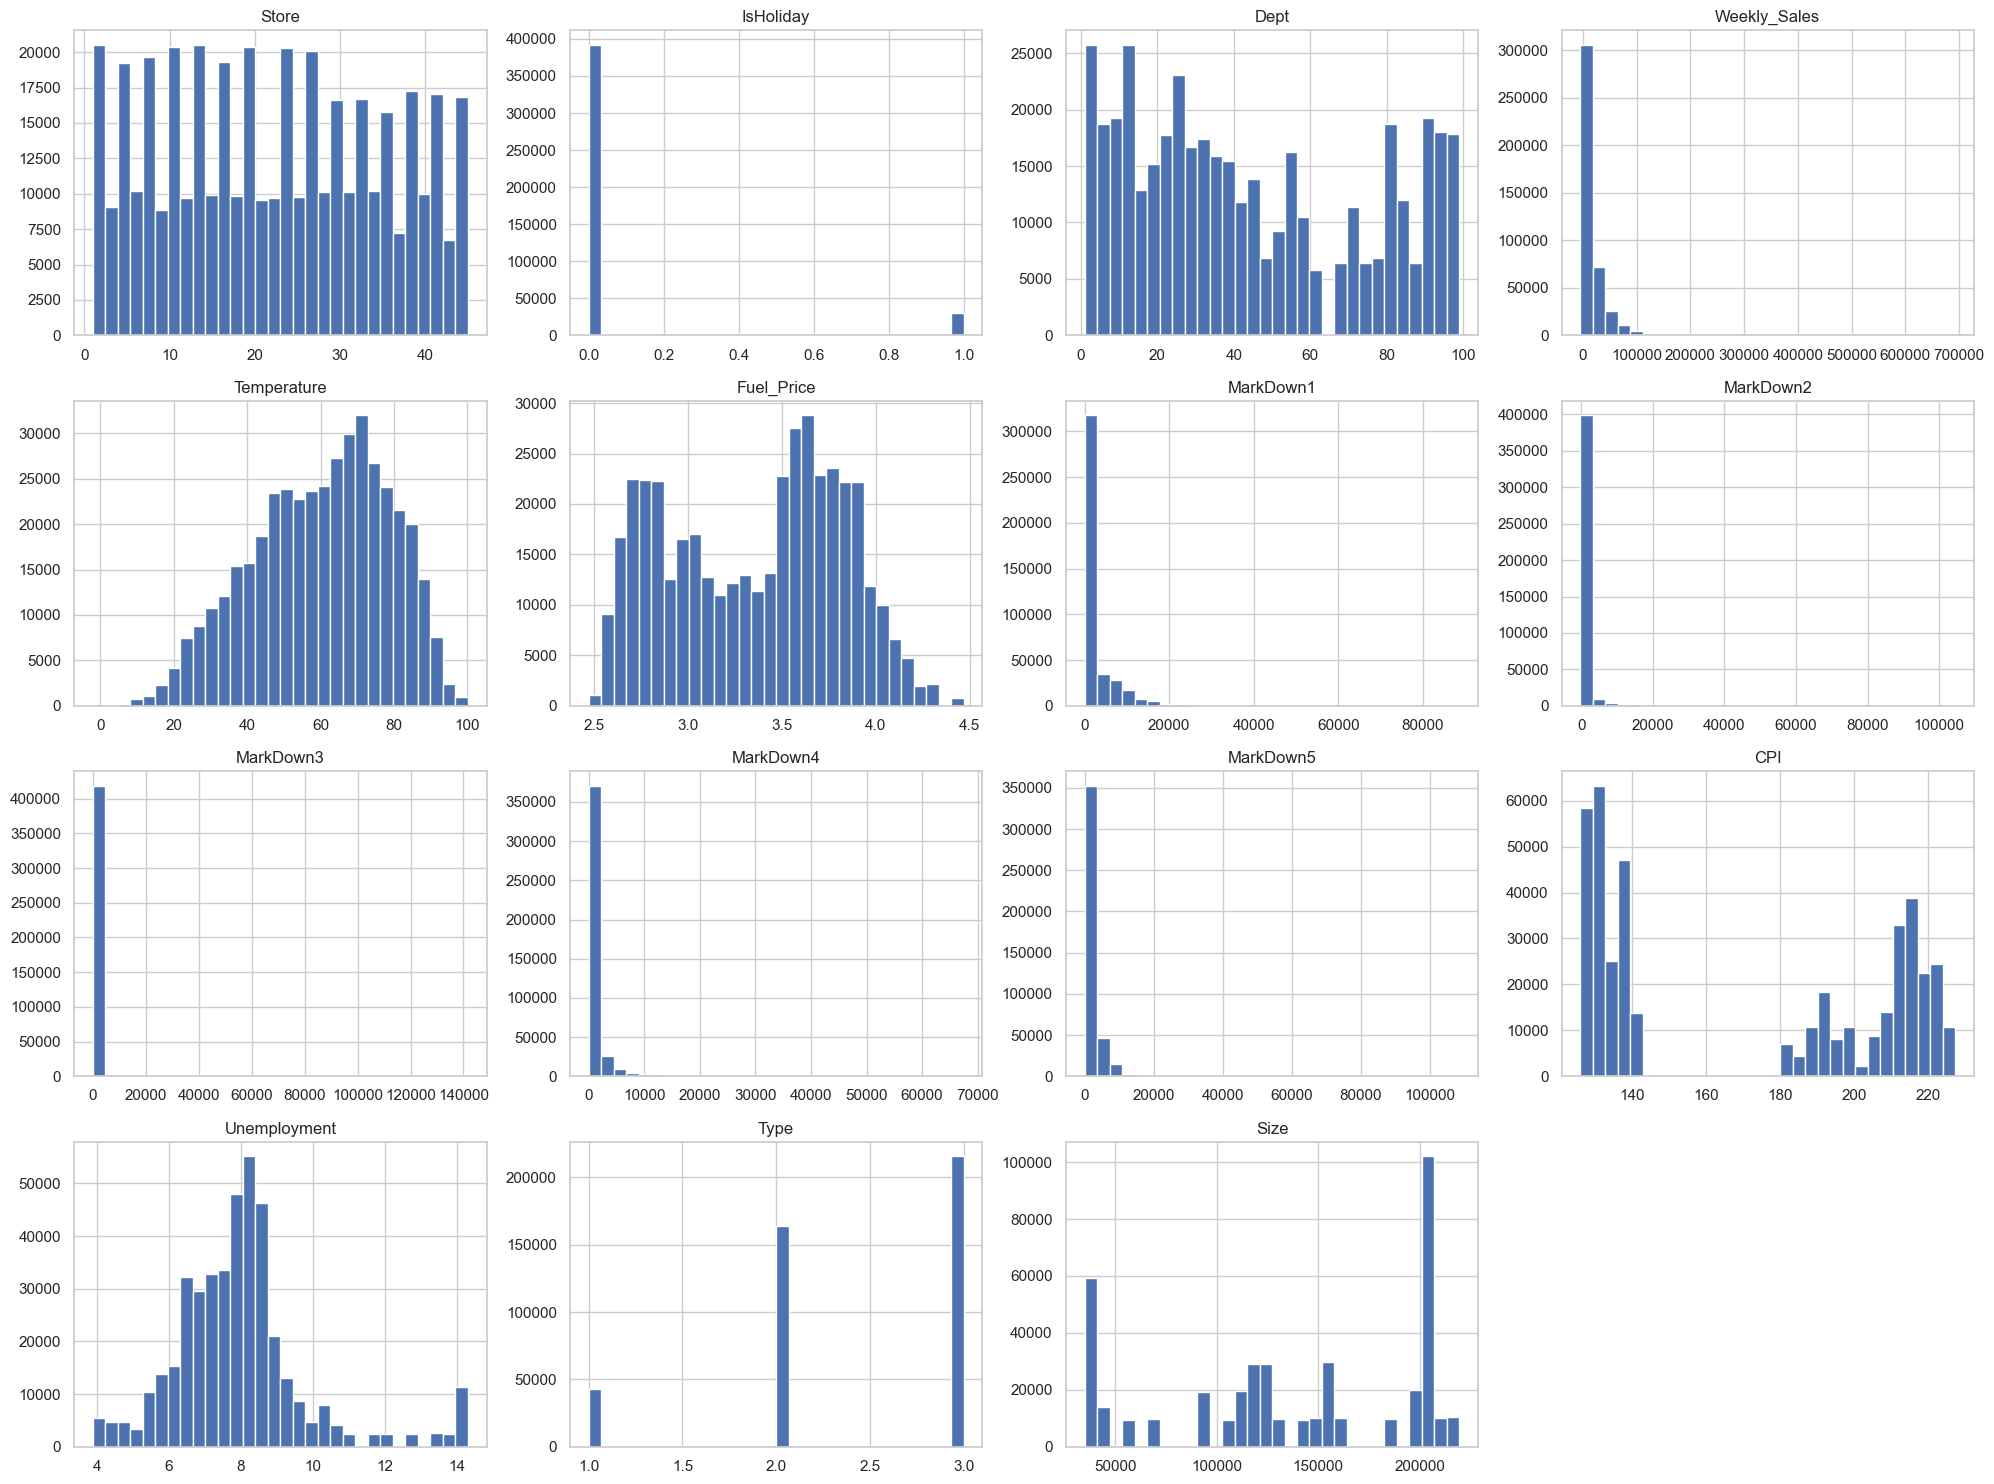

In [6]:
sns.set(style='whitegrid')
df.hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

### Correlation/Feature Selection

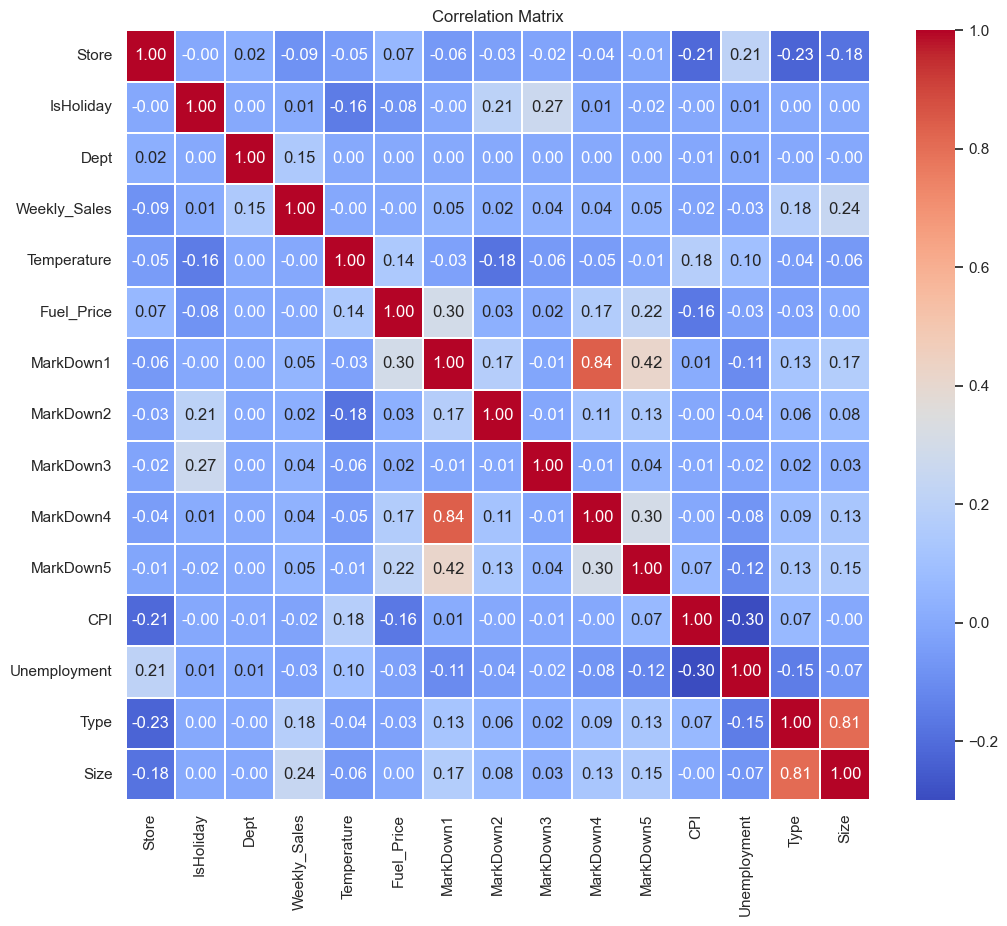

In [7]:
correlation = df.corr()
plt.figure(figsize=(12, 10))
plt.title('Correlation Matrix')
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.1)
plt.show()

- Looks like the correlation matrix shows that none of our features are heavily correlated with eachother other than the type and the size. 

- Thefore we may want to drop one of these features when trianing the model as it is not providing more information and just increasing dimensionality. 

In [20]:
df = feature_engineering(df)

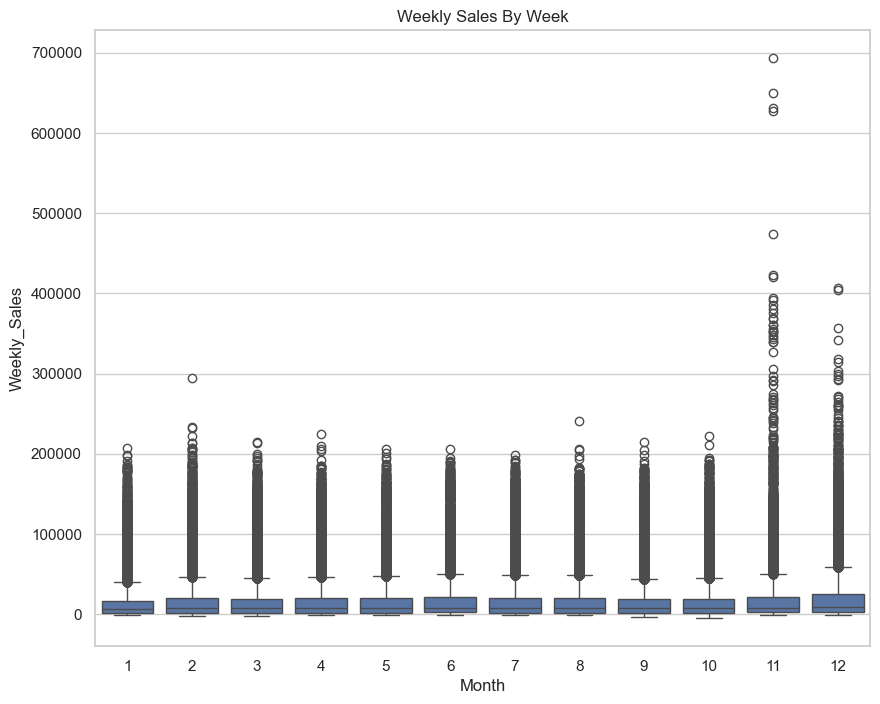

In [22]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='Weekly_Sales')
plt.title('Weekly Sales By Week')
plt.show()

 - From the box plot we can actually see that most Walmart stores actually do not have much seasonality in their data other than a few outliers.

### Time-Series Visualization
- Full Time Series Plot
- Weekly Time Series Plot

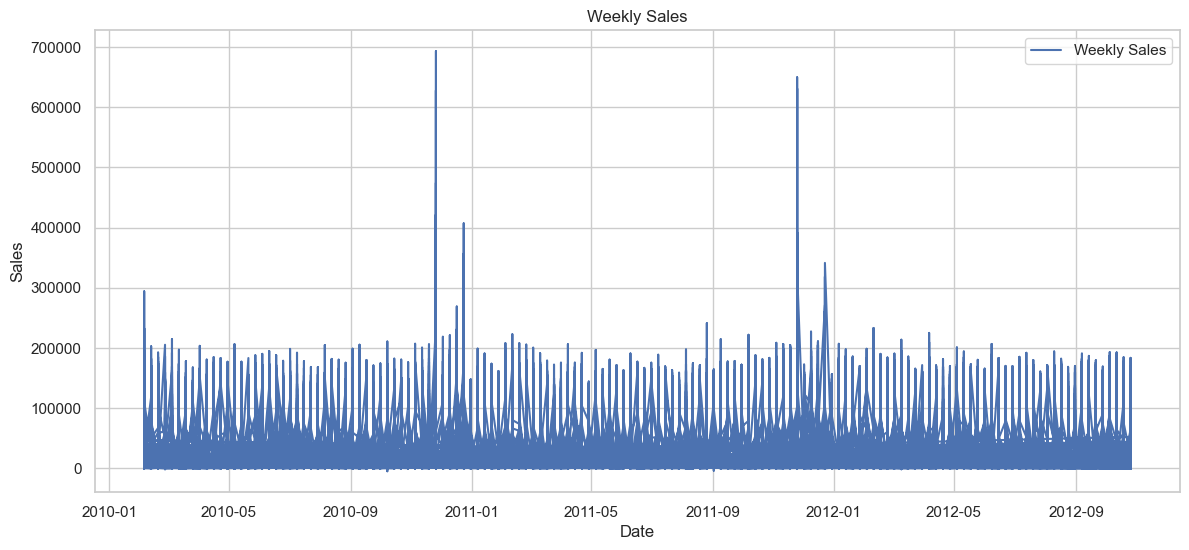

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df['Weekly_Sales'], label='Weekly Sales')
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

- We can see that there is some seasonality in this data that is inflating the sales during the December time each year, but we know from our box plots that these are mostly outlier values and stores that are showing these big spikes.

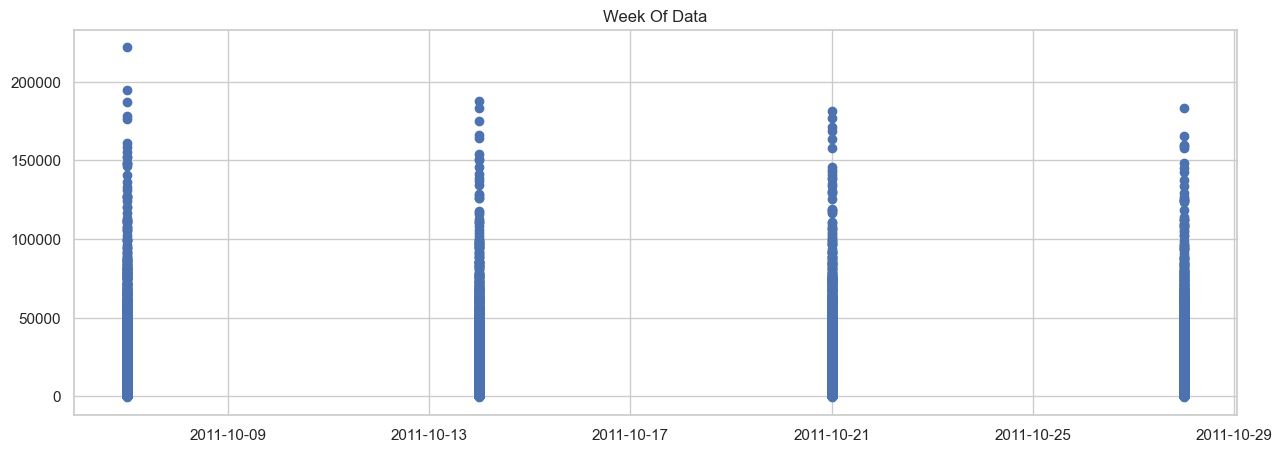

In [15]:
time_frame = df.loc[(df.index > '2011-10-01') & (df.index < '2011-11-01')]
plt.figure(figsize=(15,5))
plt.scatter(time_frame.index, time_frame['Weekly_Sales']) 
plt.title('Week Of Data')
plt.show()

- This shows us all the sales for the different Walmart stores of varying locations and sizes.

### Holidays

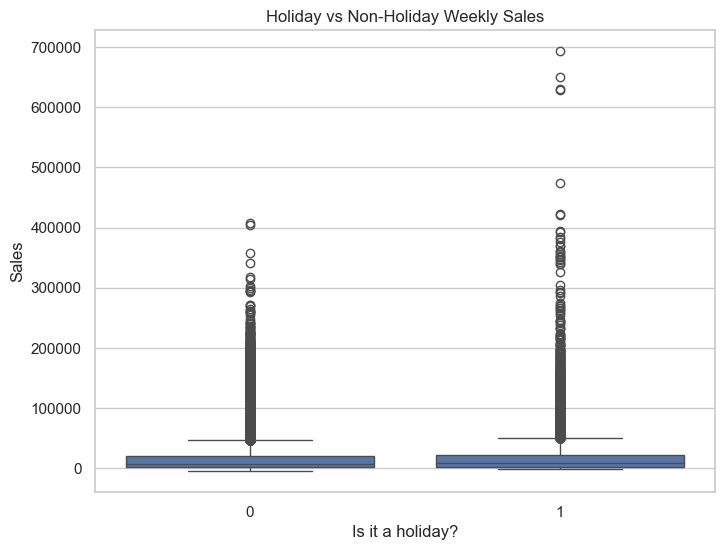

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=df)
plt.title('Holiday vs Non-Holiday Weekly Sales')
plt.xlabel('Is it a holiday?')
plt.ylabel('Sales')
plt.show()

 - Holidays make very little impact on the overall sales of Walmart stores other than a few different outliers. 

### Outliers

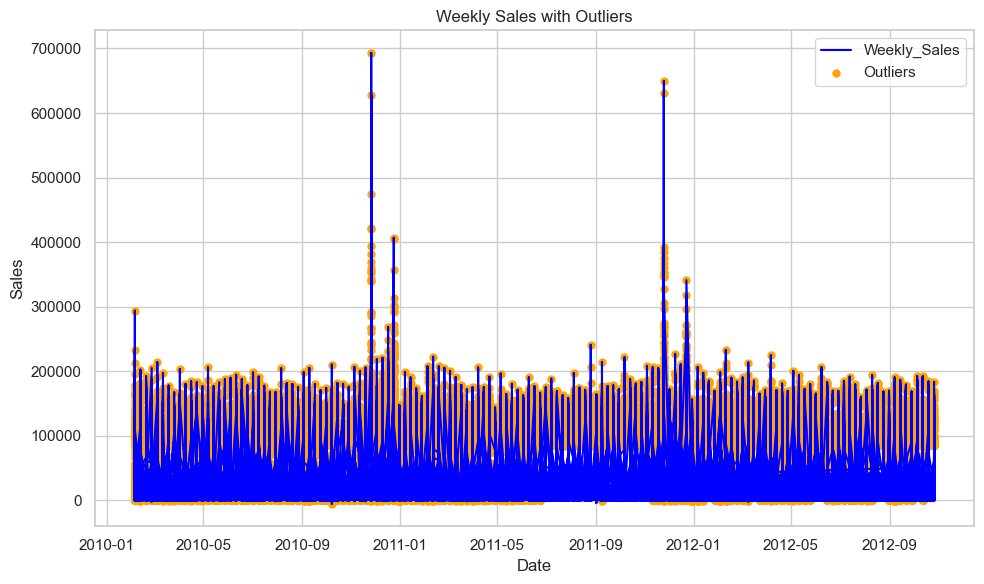

In [11]:
from scipy.stats import zscore
z_scores = np.abs((zscore(df))) #calcuate the z-scores across all features of the dataframe
threshold = 3
outliers = (z_scores > threshold).any(axis=1) #find the outliers that are more than 3 standard deviations away from the mean

plt.figure(figsize=(10,6))
plt.plot(df['Weekly_Sales'], label='Weekly_Sales', color = 'blue')
plt.scatter(df.index[outliers], df.loc[outliers, 'Weekly_Sales'], color='orange', marker='o', s=25, label='Outliers')
plt.title('Weekly Sales with Outliers')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- In the above we can clearly see that the outliers that were detected form the z-score do not seem to be outliers at all. So, for our purposes I do not think I will get rid of these outliers. 